<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_13_2D_to_3D_camera_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camera Calibration

Without the lens distortion,  the transformation of the 3D point to the image point (in homogeneous coordinates) is given as a product of a 3 by 3 intrinsic camera parameter $\mathbf{K}$ and a 3 by 4 extrinsic parameter matrix composed of a 3 by 3 rotation matrix, $\mathbf{R}$, and a 3 by 1 translation vector $\mathbf{t}$.
\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} -f & 0 & c_x  & 0\\ 0 & -af & c_y & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix}
    \begin{bmatrix} 
    r_{00} & r_{01} & r_{02} & t_x \\ 
    r_{10} & r_{11} & r_{12} & t_y \\
    r_{20} & r_{21} & r_{22} & t_z \\
    0 & 0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}}_c & = & \mathbf{K} \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix} \mathbf{\tilde{p}} 
\end{eqnarray}

The task of calibration is to be able to derive the intrinsic $\mathbf{K}$ and extrinsic parameters, $\begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}$, given pairs  consisting of 3D points, with respect to the world, $\mathbf{\tilde{X}}_p$, and their imaged location in terms of row and column in the image, $\mathbf{\tilde{x}}_c$.

We will break up this estimation into two steps. First we will estimate the lumped parameters of the intrinsic and extrinsic parts. Next we will disentangle these in intrinsic and extrinsic parts from the lumped parameter estimates using linear algebra.

The extrinsic and intrinsic matrices can be multiplied together into one lump parameter matrix $\mathbf{P} = \begin{bmatrix} \mathbf{K} \mathbf{R} & \mathbf{K}  \mathbf{t} \end{bmatrix} $.


\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} 
    p_{00} & p_{01} & p_{02} & p_{03} \\
    p_{10} & p_{11} & p_{12} & p_{13} \\
    p_{20} & p_{21} & p_{22} & p_{23} 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    x = \frac{x_1}{x_3} & = & \frac{p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
    y = \frac{x_1}{x_3} & = & \frac{p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
\end{eqnarray}

The first problem is to estimate the $p_{ij}$'s given $N$ pairs of 2D and 3D point correspondences, $\{(x_i, y_i), (X_i, Y_i, Z_i) | i = 1, \cdots, N \}$

This problem is similar to the estimation of the perspective transform estimation for 2D points that we had looked at earlier. Like before, it will involve nonlinear least squares estimation process. The difference here is the size of the parameter matrix. We have 12 unknown parameters here as opposed to nine in the other case. Estimation is a nonlinear one. The strategy we can adopt is non-linear least squares involving the following steps. 

1. Form an initial estimate of the $p_{ij}$'s using DLT.
2. Perform non-linear least square refinement of this estimate.
3. Use RQ decomposition to estimate $\mathbf{K}$, $\mathbf{R}$, and $\mathbf{t}$ the $\mathbf{P}$ matrix. 

Note that we have ignored the lens distortion in the above strategy. This distortion has to be estimated using a separate method, before you perform the above computations.


# Direct Linear Transform

\begin{eqnarray}
    x = \frac{x_1}{x_3} & = & \frac{p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
    y = \frac{x_1}{x_3} & = & \frac{p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
\end{eqnarray}


\begin{eqnarray}
    x ({p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}})& = & {p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}} \\
    y (p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}) & = & {p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}} \\
\end{eqnarray}

\begin{eqnarray}
    {p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}} - x ({p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}})  & = & 0\\
    {p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}} - y (p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23})  & = & 0\\
\end{eqnarray}

\begin{eqnarray}
   \begin{bmatrix}
    X_p & Y_p & Z_p & 1 & 0 & 0 & 0 & 0 & -x X_p & - x Y_p & -x Z_p & -x \\
    0 & 0 & 0 & 0 & X_p & Y_p & Z_p & 1 & -y X_p & - y Y_p & -y Z_p & -y
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

\begin{eqnarray}
   \begin{bmatrix}
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
      \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

\begin{eqnarray}
   \begin{bmatrix}
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}


\begin{eqnarray}
\begin{bmatrix}
\cdots & X_i & \cdots & \cdots & 0 & \cdots \\
\cdots & Y_i & \cdots & \cdots & 0 & \cdots \\
\cdots & Z_i &\cdots & \cdots & 0 & \cdots \\
\cdots & 1 & \cdots & \cdots & 0 & \cdots \\
\cdots & 0 &\cdots & \cdots & X_i &\cdots \\
\cdots & 0 &\cdots & \cdots & Y_i &\cdots \\
\cdots & 0 &\cdots & \cdots & Z_i &\cdots \\
\cdots & 0 & \cdots & \cdots & 1 &\cdots \\
\cdots & -x_i X_i &\cdots & \cdots & -y_i X_i &\cdots \\
\cdots &  - x_i Y_i &\cdots & \cdots & - y_i Y_i &\cdots \\
\cdots & -x_i Z_i & \cdots & \cdots & -y_i Z_i &\cdots \\
\cdots & -x_i &\cdots & \cdots & -y_i\cdots \\
\end{bmatrix}
\begin{bmatrix}
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}


The above can be put in the following form by moving the seven column, that multiply with $t_x = 1$, to the right as vector $\mathbf{b}$.

\begin{eqnarray}
    \mathbf{A}\mathbf{p} & = & \mathbf{b} \\
    \mathbf{A}^T \mathbf{A}\mathbf{p} & = & \mathbf{A}^T \mathbf{b} \\
    \mathbf{U} \Sigma \mathbf{V} \mathbf{p} & = & \mathbf{A}^T \mathbf{b} \\
    \mathbf{p} & = & \mathbf{V}^T \Sigma^{-1} \mathbf{U}^T \mathbf{A}^T \mathbf{b} 
\end{eqnarray}

# Function: Estimation of camera parameters using pytorch.autograd 

In [126]:

def rotation (p) :
    # returns a rotation matrix
    cos = torch.cos(p[5:8])  # cos (theta_x), cos(theta_y) cos(theta_z)
    sin = torch.sin(p[5:8])  # sin (theta_x), sin(theta_y) sin(theta_z)
    R_00 =  cos[2]*cos[1]
    R_01 = -sin[2]*cos[0] - cos[2]*sin[1]*sin[0]
    R_02 =  sin[2]*sin[0] - cos[2]*sin[1]*cos[0]

    R_10 =  sin[2]*cos[1]
    R_11 =  cos[2]*cos[0] + sin[2]*sin[1]*sin[0]
    R_12 = -cos[2]*sin[0] + sin[2]*sin[1]*cos[0]

    R_20 = -sin[1]
    R_21 =  cos[1]*sin[0]
    R_22 =  cos[1]*cos[0]

    return(R_00)

p = torch.tensor([0.026, 1/1.22e-6, 1/1.22e-6, 2500, 2500, 0,0, 30*(22.0/7.0)/180, 0, 0, 0, 0, 20, 3600, 5000], device=device, dtype=torch.double, requires_grad=True)

Hessian = torch.autograd.functional.hessian(rotation, p) 
print(Hessian)

residual = rotation (p)
residual.backward()
print(p.grad)

tensor([[ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.00, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.00, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.00, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.00, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.00, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.00, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00, -0.87, -0.00,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  0.00,  0.00, -0.00,  0.00, -0.87,  0.00,  0.00,
          0.00,  0.00,  0.00,  0.00,  0.00],
        

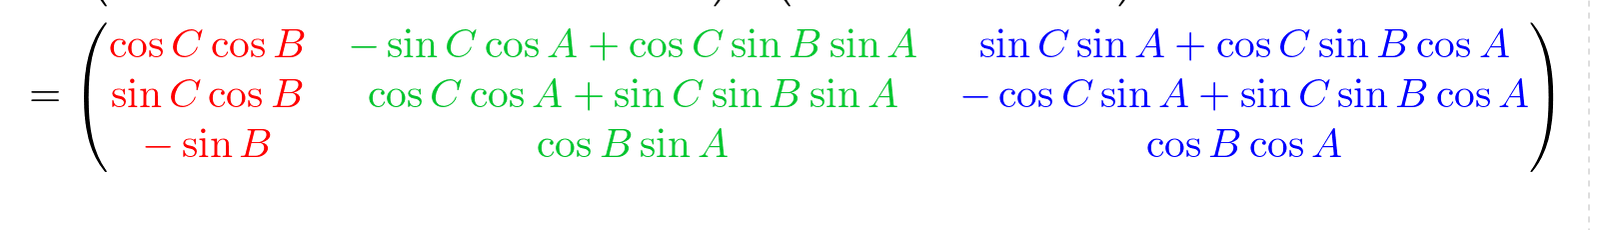

In [114]:
p = torch.tensor([0.026, 1/1.22e-6, 1/1.22e-6, 2500, 2500, 0,0, 30*(22.0/7.0)/180, 0, 0, 0, 0, 20, 3600, 5000], device=device, dtype=torch.double, requires_grad=True)
cos = torch.cos(p[5:8])  # cos (theta_x), cos(theta_y) cos(theta_z)
sin = torch.sin(p[5:8])  # sin (theta_x), sin(theta_y) sin(theta_z)
R_00 =  cos[2]*cos[1]
R_01 = -sin[2]*cos[0] - cos[2]*sin[1]*sin[0]
R_02 =  sin[2]*sin[0] - cos[2]*sin[1]*cos[0]

R_10 =  sin[2]*cos[1]
R_11 =  cos[2]*cos[0] + sin[2]*sin[1]*sin[0]
R_12 = -cos[2]*sin[0] + sin[2]*sin[1]*cos[0]

R_20 = -sin[1]
R_21 =  cos[1]*sin[0]
R_22 =  cos[1]*cos[0]


R = torch.tensor([[R_00, R_01, R_02], [R_10, R_11, R_12], [R_20, R_21, R_22]])
print(p[5:8], '\n',  cos, '\n', sin, '\n', R)

tensor([0.00, 0.00, 0.52], dtype=torch.float64, grad_fn=<SliceBackward>) 
 tensor([1.00, 1.00, 0.87], dtype=torch.float64, grad_fn=<CosBackward>) 
 tensor([0.00, 0.00, 0.50], dtype=torch.float64, grad_fn=<SinBackward>) 
 tensor([[ 0.87, -0.50,  0.00],
        [ 0.50,  0.87,  0.00],
        [-0.00,  0.00,  1.00]], dtype=torch.float64)


0 0.023981630893148316
4 0.036112886765138394
8 0.036744467275885755
12 0.036747611240010095
16 0.03674762956692899
20 0.03674762964088443
24 0.03674762964117392
28 0.036747629641175054
32 0.03674762964117506
36 0.03674762964117506
40 0.036747629641175054
44 0.03674762964117506
48 0.036747629641175054
52 0.03674762964117506
56 0.03674762964117506
60 0.03674762964117506
64 0.036747629641175054
68 0.036747629641175054
72 0.036747629641175054
76 0.036747629641175054
80 0.036747629641175054
84 0.036747629641175054
88 0.036747629641175054
92 0.036747629641175054
96 0.03674762964117506
100 0.03674762964117506
104 0.036747629641175054
108 0.03674762964117506
112 0.036747629641175054
116 0.036747629641175054
120 0.036747629641175054
124 0.036747629641175054
128 0.036747629641175054
132 0.036747629641175054
136 0.036747629641175054
140 0.036747629641175054
144 0.036747629641175054
148 0.036747629641175054
152 0.036747629641175054
156 0.036747629641175054
160 0.036747629641175054
164 0.036747629

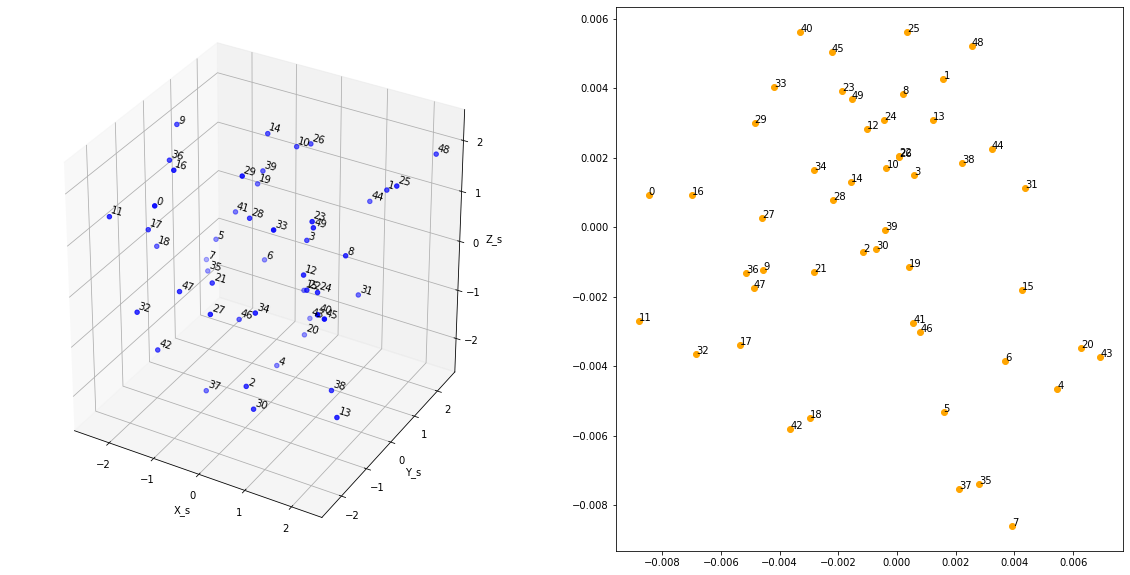

In [164]:
''' Randomly generate 3D points point with respect to the world '''
import numpy as np
import torch
import matplotlib.pyplot as plt
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU

def calibrate_camera_demo () :

    def forward_projective (p, X_w) :
        '''13 parameters: f, 1/s_x, 1/s_y, c_x, c_y, theta_x, theta_y, theta_z, t_x, t_y, t_z, kappa1, kappa2'''
        ''''              0,   1  ,   2  ,  3,   4 ,   5    ,    6   ,    7,      8,  9,   10,   11,    12 '''

        ''' world-camera coordinate transform'''
        cos = torch.cos(p[0:3])  # cos (theta_x), cos(theta_y) cos(theta_z)
        sin = torch.sin(p[0:3])  # sin (theta_x), sin(theta_y) sin(theta_z)
        R_00 =  cos[2]*cos[1]
        R_01 = -sin[2]*cos[0] - cos[2]*sin[1]*sin[0]
        R_02 =  sin[2]*sin[0] - cos[2]*sin[1]*cos[0]

        R_10 =  sin[2]*cos[1]
        R_11 =  cos[2]*cos[0] + sin[2]*sin[1]*sin[0]
        R_12 = -cos[2]*sin[0] + sin[2]*sin[1]*cos[0]

        R_20 = -sin[1]
        R_21 =  cos[1]*sin[0]
        R_22 =  cos[1]*cos[0]
        
        X_c = R_00*X_w[:,0,:] + R_01*X_w[:,1,:] + R_02*X_w[:,2,:] + p[3]
        Y_c = R_10*X_w[:,0,:] + R_11*X_w[:,1,:] + R_12*X_w[:,2,:] + p[4]
        Z_c = R_20*X_w[:,0,:] + R_21*X_w[:,1,:] + R_22*X_w[:,2,:] + p[5]


        '''Perspective projection'''
        x_c = 0.026*torch.div(X_c, Z_c)
        y_c = 0.026*torch.div(Y_c, Z_c)
        
        ''' Lens distortion'''
        #x_c_hat = x_c #len_distortion(p[11], p[12], x_c)

        ''' shift to image pixel coordinates'''
        #T_pixel = torch.tensor([[p[1], 0, p[3]], [0, p[2], p[4]],[0, 0, 1]], device=device) 
        #x_s = shift_to_array_coords(T_pixel, x_c_hat)

        return (x_c, y_c)

    def len_distortion (kappa1, kappa2, x) :
        ''' applies lens distorion on the principal point centered coordinates x(N,3,1)'''
        r_sq = x[:,0,:]**2 + x[:,1,:]**2
        distortion_factor = 1 + kappa1*r_sq + kappa2*r_sq*r_sq
        x_hat = x * distortion_factor[:,None,:]
        x_hat[:,2,0] = torch.ones((x_hat.shape[0],)) # fix the third homogenous coordinates to 1
        return (x_hat)

    def shift_to_array_coords (T, x) :
        ''' shift image locations, x(N,3,1), T = 3 by 3 matrix to shift coordinates '''
        return(torch.matmul(T, x))

    def SSD_error (parameters) :
        # Note X_world_gt, x_image_gt is not defined in this function scope
        x_image, y_image = forward_projective (parameters, X_world_gt)
        #print(x_image)
        #print(x_image_gt)
        error = (torch.pow(x_image - x_image_gt, 2) + 
                 torch.pow(y_image - y_image_gt, 2)).sum()
        return(error)

    def generate_3D_2D_point_set (parameters) :
        N = 50
        X_world = 5*(np.random.rand(N, 4, 1) - 0.5)
        X_world[:,3,0] = np.ones((N,))
        X_world = torch.tensor(X_world, device=device, requires_grad=False, dtype=torch.double)
        x_s, y_s = forward_projective (p, X_world)
        return(x_s, y_s, X_world)


    '''13 parameters: f, 1/s_x, 1/s_y, c_x, c_y, theta_x, theta_y, theta_z, t_x, t_y, t_z, kappa1, kappa2'''
    #p = torch.tensor([0.026, 1/1.22e-6, 1/1.22e-6, 2500, 2500, 30*(22.0/7.0)/180, -30*(22.0/7.0)/180, 20*(22.0/7.0)/180, 0, 0, 10, 3600, 5000], device=device, dtype=torch.double, requires_grad=True)
    f = 0.026  # in meters -- iphone 11 camera focal length = 26 mm
    p = torch.tensor([30*(22.0/7.0)/180, -30*(22.0/7.0)/180, 20*(22.0/7.0)/180, 0, 0, 10], device=device, dtype=torch.double, requires_grad=True)
    
    x_image_gt, y_image_gt, X_world_gt = generate_3D_2D_point_set (p)
    #print(X_world_gt, x_image_gt)

    p_k = torch.tensor([ 0, 0, 0, 0, 0, 10], 
                       device=device, dtype=torch.double, requires_grad=True)
    learning_rate = 1
    for t in range(200):
        Hessian = torch.autograd.functional.hessian(SSD_error, p_k) 
        #print(Hessian)
        residual = SSD_error (p_k)/x_image_gt.shape[1]
        # Compute and print residual using operations on Tensors.
        # Now residual is a Tensor of shape (1,)
      
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call H.grad, will be a Tensor holding the gradient of 
        # the loss with respect to entries of H.
        
        residual.backward(retain_graph=True)
        #print(p_k.grad)
        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            if (torch.abs(torch.det(Hessian)) > 0) :
                #print(Hessian)
                del_p = learning_rate * torch.inverse(Hessian) @ p_k.grad
            else:
                del_p = learning_rate *  p_k.grad
            p_k -= del_p
            if (np.remainder(t, 4) == 0) :
                print(t, np.sqrt(residual.item())) # *.item() gets the scalar value held.
                #print('h.grad = \n', h_8_est.grad, '\n del_p\n', del_p)
            # Manually zero the gradients after updating weights
            p_k.grad = None


    print(p)
    print(p_k)

    # -----------------------------DISPLAY--------------------------------------------
    x_image_gt = x_image_gt.detach().numpy()
    y_image_gt = y_image_gt.detach().numpy()
    X_world_gt = X_world_gt.detach().numpy()
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,2,1, projection='3d')
    ax.scatter(X_world_gt[:,0,0], X_world_gt[:,1,0], X_world_gt[:,2,0], c='b', marker='o')
    ax.set_xlabel('X_s')
    ax.set_ylabel('Y_s')
    ax.set_zlabel('Z_s')
    N = X_world_gt.shape[0]
    for i in range(N):
        ax.text(X_world_gt[i,0,0], X_world_gt[i,1,0], X_world_gt[i,2,0], '{}'.format(i), 'x')
    plt.subplot(1,2,2)
    plt.plot(y_image_gt, x_image_gt, c='orange', marker='o', linewidth=0)
    for i in range(N):
        plt.annotate('{}'.format(i), (y_image_gt[i], x_image_gt[i]))


calibrate_camera_demo ()


# Tsai calibration

A long-standing, complete solution, calibration method is the one developed by Roger Tsai in 1987. The steps involved in this method are outlined below. It estimates both intrinsic and the extrinsic parameters of the camera. It also account for the lens distortion.

1. Image a target of known 3D geometry. The target should have points on it that can easily imaged. They should be distributed across all three dimensions. The image of the calibration object should occupy the entire image. Sometimes, instead of the calibration object, we establish a coordinate axis in the 3D scene with respect to some real 3D point such as the corner of a room and choose 3D points from the scene, based on actual 3D dimensions.

2. Establish correspondences between 3D target points, with respect to the world coordinates, and their 2D image location in pixel coordinates.

3. Obtain estimates of as many parameters as possible using linear least-squares fitting methods, which are fast. 

>> * Estimate rotation and parts of the translation vector using first form of DLT.
>> * Estimate the rest of the translation vector and focal length using the second form of the DLT.

4. Impose orthogonality of the rotation matrix estimates.  This does not affect the final result, since these estimated parameter values are used only as starting values for the final optimization, which is the next step.

5. The rest of the parameters are obtained using a nonlinear optimization method that finds the best fit between the observed image points and those predicted from the target model. Note that the DLT does not minimize the error in the image projection, but some other unknown quantity that led to convenient, linear equations. The resulting rotation matrix and translation components are not especially accurate as a result. This is acceptable only because we use the recovered values merely as estimates in the full non-linear optimization using the iterative method described in the textbook and the Tsai paper.


# First form of Direct Linear Transform (DLT)

* What is the ratio of $x_s - c_x$  and $y_s - c_y$? Assume that we have a good initial estimate of the optic center, $(c_x, c_y)$. Usually, the center of the image is a good estimate.
    
\begin{equation}
    \frac{x_s - c_x}{y_s - c_y} = 
\end{equation}
    
* Rewrite the above in the following form.
    
\begin{eqnarray}
(~~~~~~~~)r_{00}  + (~~~~~~~~)r_{01}  + (~~~~~~~~)r_{02}+   \\
(~~~~~~~~)a r_{10}  + (~~~~~~~~) a r_{11}  + (~~~~~~~~)a r_{12}+& \\
(~~~~~~~~)r_{10}  + (~~~~~~~~)r_{11}  + (~~~~~~~~)r_{12} +  \\
(~~~~~~~~) t_x  + (~~~~~~~~) t_y  + (~~~~~~~~) t_z  = 0
\end{eqnarray}

We get one such equation for each 2D-3D point pair. The unknown (eight) parameter vector is given by 

\begin{equation}
    \begin{bmatrix}
    r_{00} & r_{01} & r_{02} & 
    a r_{10} & a r_{11} & a r_{12} &
    t_x & a t_y  
    \end{bmatrix}^T
\end{equation}

There is an unknown scale factor. If we have a solution for the eight unknowns, then any multiple of that solution is also a solution. In order to obtain an unique solution, we can arbitrarily set one unknown, $t_x$ say — to one. (Assumes some relationship among the origins of the camera and the world. What is it?) So, we end up with 7 unknowns. So we need seven pairs of 2D-3D point correspondences.

Note the third row of the rotation matrix is not being estimated here. Hang on, we have a trick up our sleeves. If we can estimate the first two rows of the rotation matrix, we can infer the third from the orthogonality constraint. More on that a bit later.

Let $y'=y_s - c_y$ and $x'=x_s - c_x$.

\begin{equation}
    \begin{bmatrix}
    \vdots & \vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots \\
    \vdots & \vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots \\
    X_w y' & Y_w y' & Z_w y' &  y' &
    -X_w x' & - Y_w x' & - Z_w x' &  - x' \\
    \vdots & \vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots \\
    \vdots & \vdots &\vdots &\vdots &\vdots &\vdots &\vdots &\vdots \\
    \end{bmatrix}
    \begin{bmatrix}
        r_{00} \\ r_{01} \\ r_{02} \\ 
        a r_{10} \\ a r_{11} \\ a r_{12} \\
        1 \\ a t_y  
    \end{bmatrix} = 0
\end{equation}

The above can be put in the following form by moving the seven column, that multiply with $t_x = 1$, to the right as vector $\mathbf{b}$.

\begin{eqnarray}
    \mathbf{A}\mathbf{p} & = & \mathbf{b} \\
    \mathbf{A}^T \mathbf{A}\mathbf{p} & = & \mathbf{A}^T \mathbf{b} \\
    \mathbf{U} \Sigma \mathbf{V} \mathbf{p} & = & \mathbf{A}^T \mathbf{b} \\
    \mathbf{p} & = & \mathbf{V}^T \Sigma^{-1} \mathbf{U}^T \mathbf{A}^T \mathbf{b} 
\end{eqnarray}

Can we always do this? Think about it.

From the estimated $\mathbf{p} = \begin{bmatrix} p_0 & p_1 & \cdots & p_6 \end{bmatrix}^T$ we can unravel the rotation and pixel aspect ratio ($a$) by enforcing the property of a rotation matrix. The first property that we will exploit is that the rows of the rotation matrix have unit length. Let is denote the rows of the rotation matrix by $\mathbf{r}_x^T$, $\mathbf{r}_y^T$, and $\mathbf{r}_z^T$.

\begin{eqnarray}
   ||{\mathbf{r}_x^T}||^2 =  r^2_{00} + r^2_{01} + r^2_{02}  = 1\\
   ||{\mathbf{r}_y^T}||^2 =  r^2_{10} + r^2_{11} + r^2_{12}  = 1 \\
\end{eqnarray}

Let $c_1 = \sqrt{p_0^2 + p_1^2 + p_2^2}$ and $c_2 = \sqrt{p_3^2 + p_4^2 + p_5^2}$. Divide $\mathbf{p}$ by $c_1$. The first three entries of this normalized vector will give us the first row of the rotation matrix. Normalize the next three entries of $\mathbf{p}$ to get the second row of the rotation matrix.

\begin{eqnarray}
    r_{00} = \frac{p_0}{c_1}, r_{01} = \frac{p_1}{c_1}, r_{02} = \frac{p_2}{c_1} \\
    r_{10} = \frac{p_3}{c_2}, r_{11} = \frac{p_4}{c_2}, r_{12} = \frac{p_5}{c_2} \\
    a = \frac{c_2}{c_1} \\
\end{eqnarray}

The third row of the rotation matrix is derived by imposing the constraint that the rows of the rotation matrix are orthogonal. We can get such as vector by taking the cross product of the estimates of the first two rows.

\begin{equation}
    \mathbf{r}_z = \mathbf{r}_x \times \mathbf{r}_y
\end{equation}

Note that $||{\mathbf{r}_z}|| = 1$ because the two other vectors have unit norm. The rotation matrix now satisfies all the orthogonality and normality constraints, except that the first rows are not guaranteed to be orthogonal. We can rotate the vectors $\mathbf{r}_x$ and $\mathbf{r}_y$ in the plane containing them until they are orthogonal. The operation that will accomplish is the following transformation. It is basically subtracting the dot product of the vectors from each other. If the vectors are orthogonal to begin with, the dot product will be zero and nothing will need to be changed.

\begin{eqnarray}
    \mathbf{r}_x & \leftarrow & \mathbf{r}_x - 0.5 (\mathbf{r}_x^T \mathbf{r}_y) \mathbf{r}_y \\
    \mathbf{r}_y & \leftarrow & \mathbf{r}_y - 0.5 (\mathbf{r}_x^T \mathbf{r}_y) \mathbf{r}_x \\
\end{eqnarray}

After this transformation, we need to re-normalize the vectors

\begin{eqnarray}
    \mathbf{r}_x & \leftarrow & \mathbf{r}_x/
    ||{\mathbf{r}_x}||\\
    \mathbf{r}_y & \leftarrow & \mathbf{r}_y/
    ||{\mathbf{r}_y}|| \\
\end{eqnarray}

Apart of the rotation matrix we also have estimates of parts of the translation vector

\begin{eqnarray}
t_x = \frac{p_6}{c_1}, t_y = \frac{1}{c_1}, t_z = ? 
\end{eqnarray}

We form an initial estimate of $t_z$ the focal length $f$, we use the second form of the DLT, where we ignore the lens distortion. This is considered in the next section. Note that the DLT in current section respects the lens distortion and is invariant to it as it uses the ratio of the $x-$ and $y$-coordinates.


# Second form of the DLT

TBD